In [13]:
s3_file="s3://aegovan-data/human_output/interactions_except_phys_associ.json"

interesting_interactions = ["dephosphorylation","ubiquitination", "phosphorylation", "acetylation", "deubiquitination", "demethylation","deacetylation"]

In [2]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [3]:
data_file="classification_raw_data.json"


In [4]:
%%time

download_single_file(s3_file, data_file)

In [17]:
import pandas as pd

df=pd.read_json(data_file)

In [18]:
df.head(n=3)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract
0,1459695,colocalization,true,"[{'uniprotid': 'P29590-8', 'alias': [['p29590-...",19567472,None,Maintaining proper telomere length requires th...
1,1459700,colocalization,true,"[{'uniprotid': 'P29590-1', 'alias': [['p29590-...",19567472,None,Maintaining proper telomere length requires th...
10,1197912,direct interaction,false,"[{'uniprotid': 'P51617', 'alias': [['irak1_hum...",21743479,None,Toll-like receptors (TLRs) shape innate and ad...


In [19]:
df.shape

(23151, 7)

In [20]:
df.pubmedId.unique().shape

(5766,)

In [21]:
df.interactionType.value_counts()

direct interaction                 17799
colocalization                      3790
dephosphorylation                    437
ubiquitination                       226
enzymatic reaction                   141
methylation                          134
adp ribosylation                      84
gtpase reaction                       75
acetylation                           70
deacetylation                         45
demethylation                         37
redox reaction                        33
disulfide bond                        33
deubiquitination                      31
hydroxylation                         30
atpase reaction                       29
physical interaction                  27
glycosylation                         22
putative self interaction             14
sumoylation                           13
rna cleavage                          11
self interaction                       9
genetic interaction                    9
phosphotransfer                        7
lipid cleavage  

In [22]:
def normalise_interaction_type(interaction_type):
    if interaction_type in interesting_interactions:
        return interaction_type
    else:
        return "other"

### Clean up interactions

#### Replace all except the key interactions with "other"

In [23]:
df["interactionType"] = df.apply( lambda r: normalise_interaction_type(r["interactionType"] ) , axis = 1)

In [24]:
df["interactionType"].value_counts()

other                22305
dephosphorylation      437
ubiquitination         226
acetylation             70
deacetylation           45
demethylation           37
deubiquitination        31
Name: interactionType, dtype: int64

### Make Unique as per pubmedids

In [31]:
df_clean = df.drop_duplicates(subset=['pubmedId'])
df_clean.shape

(5766, 7)

### Split Train / Test / Val 

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

train, val  = train_test_split(df_clean, test_size=.1, random_state=777, stratify=df_clean["interactionType"])


train, test = train_test_split(df_clean,  test_size=.2,
                                                        random_state=777, stratify=df_clean["interactionType"])

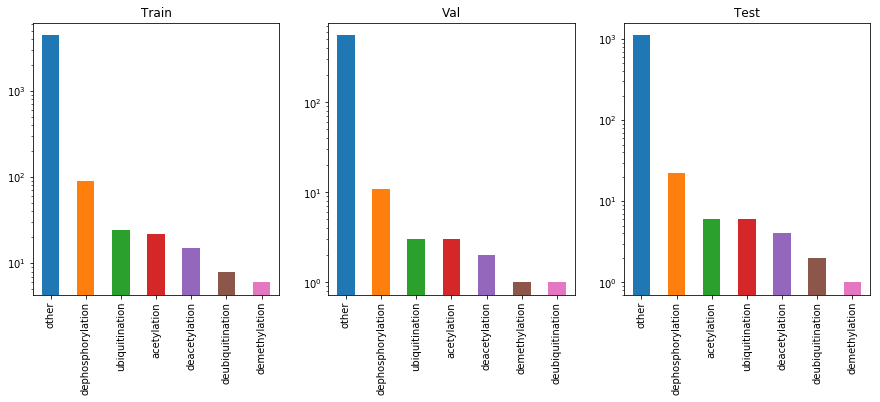

In [48]:
import matplotlib.pyplot as plt
fix, axs = plt.subplots(1,3, figsize=(15,5))


ax=axs[0]
ax.set_title("Train")
ax.set_yscale('log')
ax.xaxis.set_major_locator(plt.MaxNLocator(10, prune='lower'))
train.interactionType.value_counts().plot.bar(ax=ax)



ax=axs[1]
ax.set_title("Val")
ax.set_yscale('log')
ax.xaxis.set_major_locator(plt.MaxNLocator(10, prune='lower'))
val.interactionType.value_counts().plot.bar(ax=ax)


ax=axs[2]
ax.set_title("Test")
ax.set_yscale('log')
ax.xaxis.set_major_locator(plt.MaxNLocator(10, prune='lower'))
test.interactionType.value_counts().plot.bar(ax=ax)



plt.show()

In [50]:
train.head(n=2)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract
7200,1933855,other,false,"[{'uniprotid': 'O09118', 'alias': [['net1_mous...",26859457,None,Netrin-1 has been shown to be up-regulated in ...
14009,99582,other,false,"[{'uniprotid': 'P17655', 'alias': [['can2_huma...",10639123,None,Calpains (calcium-dependent cytoplasmic cystei...


In [52]:
train.to_json("train_classification.json")
test.to_json("test_classification.json")
val.to_json("val_classification.json")